# Exercise 5: From processing to inversion I

# Contents
 - Linear systems
 - SPOT
 - Deconvolotion

## Linear systems
A matrix is represented in Julia as follows

In [1]:
A = [1 2;3 -1]

2×2 Array{Int64,2}:
 1   2
 3  -1

The transpose of a matrix is obtained via

A'

In [2]:
A'

2×2 Array{Int64,2}:
 1   3
 2  -1

In a similar manner, we can define a column vector as follows

In [3]:
x = [2; 2]

2-element Array{Int64,1}:
 2
 2

 - Desribe two ways to define a row vector.

Now, consider the matrices



In [4]:
A1 = [1/sqrt(2) 2/3 sqrt(2)/6;0 1/3 -2*sqrt(2)/3;-1/sqrt(2) 2/3 sqrt(2)/6];
A2 = [0 2 2;2 1 -3;1 0 -2];
A3 = [3 1;1 0;2 1];
A4 = [2 4 3; 1 3 1];

# Questions

 - Look at A1'*A1, what kind of matrix is A1? What does this mean?
 - Look at A2*[1;2;3] and A2*[3;1;4], what can you say about the matrix A2?
 - What do you call a linear system defined by matrix A3?
 - What do you call a linear system defined by matrix A4?

If a matrix is invertible, we can explicitly find the inverse with inv

 - find a solution of A1*x = [6;-3;0], is there only one solution? Do you really need inv here?
 - find a solution of A2*x = [4;0;-1], is there only one solution? What characterizes the solution you found?
 - find a solution of A3*x = [5;2;5], is there only one solution? What characterizes the solution you found?
 - find a solution of A4*x = [10;5], is there only one solution? What characterizes the solution you found?


# JOLI

https://github.com/slimgroup/JOLI.jl

The JOLI toolbox gives a way to represent matrices implicitly. A nice example is the Fourier transform. In julia, the Fourier transform of a vector is given by fft(x). We can explicitly construct a matrix representing the Fourier transform as follows

In [5]:
# dimension
N  = 10
F1 = zeros(Complex{Float64}, N,N)
for k = 1:N
    # construct k-th unit vector
    ek = zeros(N,1)
    ek[k] = 1

    # make column of matrix
    F1[:, k]= fft(ek)
end


 - Look at the matrix, what do you notice?
 - Verify that it gives the same result as fft by trying on a vector

We can also define the FFT using JOLI:

In [6]:
using JOLI

In [7]:
F2  = joDFT(N)

JOLI.joLinearFunction{Float64,Complex{Float64}}("joDFTp", 10, 10, JOLI.#514, Nullable{Function}(JOLI.#278), Nullable{Function}(JOLI.#515), Nullable{Function}(JOLI.#279), false, Nullable{Function}(JOLI.#516), Nullable{Function}(JOLI.#280), Nullable{Function}(JOLI.#517), Nullable{Function}(JOLI.#281), false)

In [8]:
whos(r"F1"), whos(r"F2");

                            F1   1600 bytes  10×10 Array{Complex{Float64},2}
                            F2    582 bytes  JOLI.joLinearFunction{Float64,Comp…


And this is only a small example! The reason why we want to have such operations behave like matrices is that we can use (some) standard algorithms that where written to work with matrices to work with large scale operations. As an example we use a Gaussian matrix:

In [9]:
N  = 10000;
# NxN Gaussian matrix
G1 = ones(N, N);

In [10]:
# NxN Gaussian JOLI operator (will represent a different matrix than G1 becuase it is gerenated randomly)
G2 = joOnes(N);

In [11]:
whos(r"G1"), whos(r"G2");

                            G1 781250 KB     10000×10000 Array{Float64,2}
                            G2    246 bytes  JOLI.joMatrix{Float64,Float64}


# Deconvolution
We some signal $f(t)$ which is a convolution of some unkown signal $g(t)$ and a known filter $w(t)$. Given $f$ and $w$ we would like to retreive $g$.

For the example we use:

 

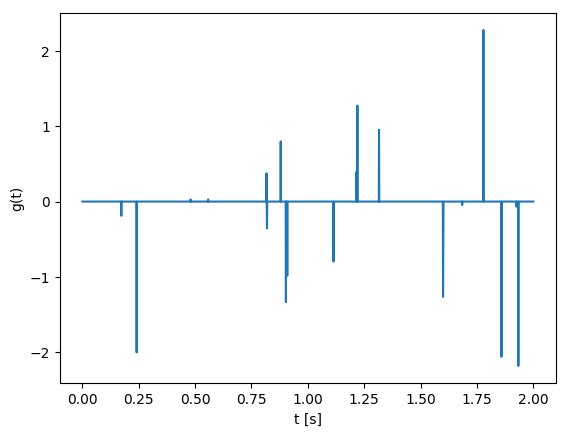

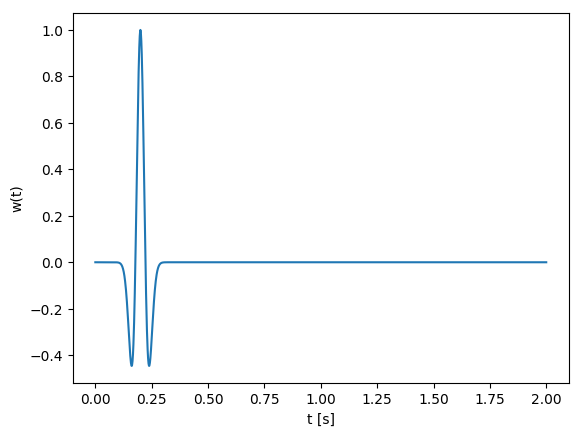

In [12]:
# time axis
t = 0:.001:2';
N = length(t);

# true signal g has approx k spikes with random amplitudes
k = 20;
g = zeros(N,1);
g[rand(1:N, k)] = randn(k,1);

# filter
w = (1-2*1e3*(t-.2).^2).*exp.(-1e3*(t-.2).^2);

# plot
using PyPlot
figure();
plot(t,g);
xlabel("t [s]");ylabel("g(t)");

figure();
plot(t,w);
xlabel("t [s]");ylabel("w(t)");

First, we consider the `forward` problem of convolving a signal, using JOLI.

Perform the convolution using the usual julia commands fft, ifft and element-wise multiplication .*.
Creat a JOLI operator to do the same. You can construct an operator to do the multiplication with the filter using joDiag.
 - Compare the results of both.
 - Compare f to g, what do you notice?
 - Assuming that your convolution operator is called C:

Now, construct the signal f using your SPOT operator and add some noise (i.e., f = C*g + 1e-1*randn(N,1)).
Do you think C has a null-space? If so, describe it. (Hint: look at the filter).
Use the adjoint of C as an approximation to the inverse, what does this correspond to and what does the reconstruction look like?
 - Describe how you would invert the system.
 - Use lsqr to do it. (you might need to increase the number of iterations.)
 - Look at the signal that is predicted by your reconstruction, do you see a difference with the true signal?

lsqr will give us a solution that has a small two-norm and explains the data. Alternatively, we can use another solver that will give us a spiky solution and explains the data. This solver is spgl1. Try spgl1(C,f,0,1e-2).

https://github.com/slimgroup/GenSPGL.jl

 - Is this solution closer to the true one?
 - Look at the predicted signal for this solution, do you see a difference with the true signal? Can we really say that this is a better solution? 

In [13]:
using GenSPGL
# Pkg.clone("https://github.com/slimgroup/GenSPGL.jl")

In [14]:
# FFT convolution
wf = fft(w);
f1 = ifft(wf.*fft(g));

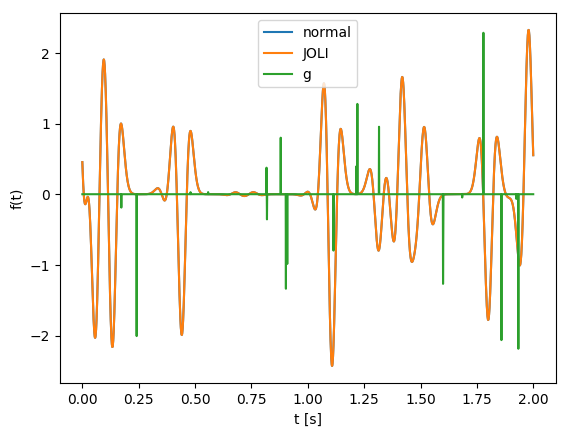

In [15]:
# JOLI operator to perform convolution.
C = joDFT(N)'*joDiag(wf)*joDFT(N);
f2 = C*g;

figure();
plot(t,f1)
plot(t,f2)
plot(t,g);
xlabel("t [s]");ylabel("f(t)");legend(["normal","JOLI", "g"]);

In [16]:
# true signal
f = C*g + 1e-3*randn(N,1);

# lsqr
gt = C\f


2001×1 Array{Float64,2}:
 0.00666159
 0.00698098
 0.00728673
 0.00760021
 0.00786498
 0.00796295
 0.00801857
 0.00814685
 0.00807513
 0.0079503 
 0.00779799
 0.00749169
 0.00719726
 ⋮         
 0.00508929
 0.00474104
 0.00452079
 0.00435027
 0.00431479
 0.00439437
 0.00467603
 0.00483907
 0.00517327
 0.00548942
 0.00585045
 0.00628071

In [17]:
# Solve
opts = spgOptions(optTol = 1e-10,
                  verbosity = 1)

#gtt, r, grads, info = spgl1(C, vec(f), tau = 0., sigma = norm(f - C*gt)) 

GenSPGL.spgOptions(1, 1, 100000, 3, 1.0e-6, 1.0e-6, 1.0e-10, 0.0001, 1.0e-16, 100000.0, 2, Inf, false, Nullable{Bool}(), Inf, [1], false, 3, 1, 10000, false, GenSPGL.NormL1_project, GenSPGL.NormL1_primal, GenSPGL.NormL1_dual, GenSPGL.funLS, false, false, false)